In [484]:
import requests
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno

# USE NEW SITES IN NOTES

## Sites
|   |Lat   |Lon   |Ozone   |PM2.5   |NO2   |
|---|---|---|---|---|---|
|LA North Main Street   |34.06653   |-118.22676   |[data](https://www.arb.ca.gov/aqmis2/display.php?param=OZONE&year=2020&units=007&report=SITE1YR&statistic=DMAX&site=2899&ptype=aqd)	   |[data](https://www.arb.ca.gov/aqmis2/display.php?param=PM25HR&units=001&year=2020&report=SITE1YR&statistic=DAVG&site=2899&ptype=aqd&monitor=-&std15=aqd)  |[data](https://www.arb.ca.gov/aqmis2/display.php?param=NO2&year=2020&units=007&report=SITE1YR&statistic=DMAX&site=2899&ptype=aqd)   |
|Compton   |33.90145   |-118.20499   |[data](https://www.arb.ca.gov/aqmis2/display.php?param=OZONE&year=2020&units=007&report=SITE1YR&statistic=DMAX&site=3743&ptype=aqd)|[data](https://www.arb.ca.gov/aqmis2/display.php?param=PM25HR&units=001&year=2020&report=SITE1YR&statistic=DAVG&site=3743&monitor=-&ptype=aqd) [AND](/Users/kevinmarlis/Downloads/ad_viz_plotval_data.csv) |[data](https://www.arb.ca.gov/aqmis2/display.php?param=NO2&year=2020&units=007&report=SITE1YR&statistic=DMAX&site=3743&ptype=aqd)   |
|Reseda   |34.19920   |-118.53275   |[data](https://www.arb.ca.gov/aqmis2/display.php?param=OZONE&year=2020&units=007&report=SITE1YR&statistic=DMAX&site=2420&ptype=aqd)  |[data](https://www.arb.ca.gov/aqmis2/display.php?param=PM25HR&units=001&year=2020&report=SITE1YR&statistic=DAVG&site=2420&monitor=-&ptype=aqd)  [AND](/Users/kevinmarlis/Downloads/ad_viz_plotval_data.csv) |[data](https://www.arb.ca.gov/aqmis2/display.php?param=NO2&year=2020&units=007&report=SITE1YR&statistic=DMAX&site=2420&ptype=aqd)   |
|Long Beach Signal Hill   |33.79371   |-118.17102   |[data](https://www.arb.ca.gov/aqmis2/display.php?param=OZONE&year=2020&units=007&report=SITE1YR&statistic=DMAX&site=3843&ptype=aqd)   |[data](https://www.arb.ca.gov/aqmis2/display.php?param=PM25HR&units=001&year=2020&report=SITE1YR&statistic=DAVG&site=3679&monitor=-&ptype=aqd) [AND](/Users/kevinmarlis/Downloads/ad_viz_plotval_data.csv) (Long Beach (South))   |[data](https://www.arb.ca.gov/aqmis2/display.php?param=NO2&year=2020&units=007&report=SITE1YR&statistic=DMAX&site=3843&ptype=aqd)   |

[EPA Pollution Data](https://www.epa.gov/outdoor-air-quality-data/download-daily-data)

[Weather Data](https://www.ncdc.noaa.gov/cdo-web/)




# Data vars

In [572]:
start_date = '2020-01-01'
end_date = '2020-12-31'
sites = ['LA', 'Compton', 'Reseda', 'LBSH']

data_path = '../AQMD data/Location Data'

datelist = pd.date_range(start_date, end_date).tolist()
datelist = [date.to_pydatetime().strftime('%Y-%m-%d') for date in datelist]

# Load CARB data

In [573]:
# Get majority of data
data = {}
sites.sort()
for site in sites:
    files = [x for x in os.listdir(data_path) if site in x]
    files.sort()
    site_data = []
    
    for f in files:
        var = f.split('_')[-1][:-4].lower()

        df = pd.read_csv(f'{data_path}/{f}', parse_dates=True, index_col=0)

        df = df[[c for c in df.columns.to_list() if var in c]]
        df = df.dropna()
        col = df.columns.to_list()[0]
        df = df.rename(columns={col: col.split('_')[0]})
        
        df.index = pd.DatetimeIndex(df.index)
        df = df.reindex(pd.date_range(start_date, end_date), fill_value=np.nan)
         
        site_data.append(df)

    merged_site_data = pd.concat(site_data, axis=1)
    
    data[site] = merged_site_data

# Fill in CARB gaps with EPA data

In [574]:
# Fill in PM2.5 gaps
f = 'EPA_PM25.csv'
var = 'Daily Mean PM2.5 Concentration'
aux_df = pd.read_csv(f'{data_path}/{f}', parse_dates=True, index_col=0)
aux_sites = ['Compton', 'Reseda', 'Long Beach (South)', 'Los Angeles-North Main Street']
aux_df = aux_df[aux_df['Site Name'].isin(aux_sites)]
aux_df = aux_df[['POC', var, 'Site Name']]

# Fill in Reseda PM2.5 values
reseda_pm_df = aux_df[(aux_df['Site Name'] == 'Reseda') & (aux_df['POC'] == 3)][var].reindex(pd.date_range(start_date, end_date), fill_value=np.nan)
data['Reseda']['pm25'] = np.where(data['Reseda']['pm25'].isnull(), reseda_pm_df, data['Reseda']['pm25'])

# Fill in Compton PM2.5 values
compton_pm_df = aux_df[(aux_df['Site Name'] == 'Compton') & (aux_df['POC'] == 1)][var].reindex(pd.date_range(start_date, end_date), fill_value=np.nan)
data['Compton']['pm25'] = np.where(data['Compton']['pm25'].isnull(), compton_pm_df, data['Compton']['pm25'])

# Fill in LA PM2.5 values
la_pm_df = aux_df[(aux_df['Site Name'] == 'Los Angeles-North Main Street') & (aux_df['POC'] == 9)][var].reindex(pd.date_range(start_date, end_date), fill_value=np.nan)
data['LA']['pm25'] = np.where(data['LA']['pm25'].isnull(), la_pm_df, data['LA']['pm25'])

# Fill in Long Beach PM2.5 values
lb_pm_df = aux_df[(aux_df['Site Name'] == 'Long Beach (South)') & (aux_df['POC'] == 3)][var].reindex(pd.date_range(start_date, end_date), fill_value=np.nan)
data['LBSH']['pm25'] = np.where(data['LBSH']['pm25'].isnull(), lb_pm_df, data['LBSH']['pm25'])

In [575]:
# Fill in NO2 gaps
f = 'EPA_NO2.csv'
var = 'Daily Max 1-hour NO2 Concentration'
aux_df = pd.read_csv(f'{data_path}/{f}', parse_dates=True, index_col=0)
aux_sites = ['Compton', 'Reseda', 'Signal Hill (LBSH)', 'Los Angeles-North Main Street']
aux_df = aux_df[aux_df['Site Name'].isin(aux_sites)]
aux_df = aux_df[['POC', var, 'Site Name']]

# Fill in Reseda NO2 values
reseda_pm_df = aux_df[(aux_df['Site Name'] == 'Reseda') & (aux_df['POC'] == 2)][var].reindex(pd.date_range(start_date, end_date), fill_value=np.nan)
data['Reseda']['no2'] = np.where(data['Reseda']['no2'].isnull(), reseda_pm_df, data['Reseda']['no2'])

# Fill in Compton NO2 values
compton_pm_df = aux_df[(aux_df['Site Name'] == 'Compton') & (aux_df['POC'] == 1)][var].reindex(pd.date_range(start_date, end_date), fill_value=np.nan)
data['Compton']['no2'] = np.where(data['Compton']['no2'].isnull(), compton_pm_df, data['Compton']['no2'])

# Fill in LA NO2 values
la_pm_df = aux_df[(aux_df['Site Name'] == 'Los Angeles-North Main Street') & (aux_df['POC'] == 3)][var].reindex(pd.date_range(start_date, end_date), fill_value=np.nan)
data['LA']['no2'] = np.where(data['LA']['no2'].isnull(), la_pm_df, data['LA']['no2'])

# Fill in Long Beach NO2 values
lb_pm_df = aux_df[(aux_df['Site Name'] == 'Signal Hill (LBSH)') & (aux_df['POC'] == 1)][var].reindex(pd.date_range(start_date, end_date), fill_value=np.nan)
data['LBSH']['no2'] = np.where(data['LBSH']['no2'].isnull(), lb_pm_df, data['LBSH']['no2'])

In [576]:
# Fill in Ozone gaps
f = 'EPA_OZONE.csv'
var = 'Daily Max 8-hour Ozone Concentration'
aux_df = pd.read_csv(f'{data_path}/{f}', parse_dates=True, index_col=0)
aux_sites = ['Compton', 'Reseda', 'Signal Hill (LBSH)', 'Los Angeles-North Main Street']
aux_df = aux_df[aux_df['Site Name'].isin(aux_sites)]
aux_df = aux_df[['POC', var, 'Site Name']]

# Fill in Reseda NO2 values
reseda_pm_df = aux_df[(aux_df['Site Name'] == 'Reseda') & (aux_df['POC'] == 1)][var].reindex(pd.date_range(start_date, end_date), fill_value=np.nan)
data['Reseda']['ozone'] = np.where(data['Reseda']['ozone'].isnull(), reseda_pm_df, data['Reseda']['ozone'])

# Fill in Compton NO2 values
compton_pm_df = aux_df[(aux_df['Site Name'] == 'Compton') & (aux_df['POC'] == 1)][var].reindex(pd.date_range(start_date, end_date), fill_value=np.nan)
data['Compton']['ozone'] = np.where(data['Compton']['ozone'].isnull(), compton_pm_df, data['Compton']['ozone'])

# Fill in LA NO2 values
la_pm_df = aux_df[(aux_df['Site Name'] == 'Los Angeles-North Main Street') & (aux_df['POC'] == 1)][var].reindex(pd.date_range(start_date, end_date), fill_value=np.nan)
data['LA']['ozone'] = np.where(data['LA']['ozone'].isnull(), la_pm_df, data['LA']['ozone'])

# Fill in Long Beach NO2 values
lb_pm_df = aux_df[(aux_df['Site Name'] == 'Signal Hill (LBSH)') & (aux_df['POC'] == 1)][var].reindex(pd.date_range(start_date, end_date), fill_value=np.nan)
data['LBSH']['ozone'] = np.where(data['LBSH']['ozone'].isnull(), lb_pm_df, data['LBSH']['ozone'])

# Add climate data

In [577]:
# Compton -> HAWTHORNE MUNICIPAL AIRPORT, CA US
# Reseda -> WOODLAND HILLS PIERCE COLLEGE, CA US
# LA -> LOS ANGELES DOWNTOWN USC, CA US
# LB -> LONG BEACH DAUGHERTY AIRPORT, CA US

f = 'Climate.csv'
climate_df = pd.read_csv(f'{data_path}/{f}', parse_dates=True)

In [578]:
# Compton climate
compton_climate_df = climate_df[climate_df['NAME'] == 'HAWTHORNE MUNICIPAL AIRPORT, CA US']
compton_climate_df.index = pd.DatetimeIndex(compton_climate_df.DATE)
compton_climate_df = compton_climate_df.reindex(pd.date_range(start_date, end_date), fill_value=np.nan)
compton_climate_df = compton_climate_df[['PRCP', 'AWND', 'TMAX', 'TMIN']]
data['Compton'] = pd.concat([data['Compton'], compton_climate_df], axis=1)

# Long Beach climate
lb_climate_df = climate_df[climate_df['NAME'] == 'LONG BEACH DAUGHERTY AIRPORT, CA US']
lb_climate_df.index = pd.DatetimeIndex(lb_climate_df.DATE)
lb_climate_df = lb_climate_df.reindex(pd.date_range(start_date, end_date), fill_value=np.nan)
lb_climate_df = lb_climate_df[['PRCP', 'AWND', 'TMAX', 'TMIN']]
data['LBSH'] = pd.concat([data['LBSH'], lb_climate_df], axis=1)

# Reseda climate
reseda_climate_df = climate_df[climate_df['NAME'] == 'WOODLAND HILLS PIERCE COLLEGE, CA US']
reseda_climate_df.index = pd.DatetimeIndex(reseda_climate_df.DATE)
reseda_climate_df = reseda_climate_df.reindex(pd.date_range(start_date, end_date), fill_value=np.nan)
reseda_climate_df = reseda_climate_df[['PRCP', 'AWND', 'TMAX', 'TMIN']]
data['Reseda'] = pd.concat([data['Reseda'], reseda_climate_df], axis=1)

# LA climate
la_climate_df = climate_df[climate_df['NAME'] == 'LOS ANGELES DOWNTOWN USC, CA US']
la_climate_df.index = pd.DatetimeIndex(la_climate_df.DATE)
la_climate_df = la_climate_df.reindex(pd.date_range(start_date, end_date), fill_value=np.nan)
la_climate_df = la_climate_df[['PRCP', 'AWND', 'TMAX', 'TMIN']]
data['LA'] = pd.concat([data['LA'], la_climate_df], axis=1)

# Interpolate nans and remove outliers

In [579]:
from scipy import stats

for site, df in data.items():
    for col in df.columns:
#         Replace outliers with nan
        df[col] = np.where(np.abs(stats.zscore(df[col])) > 3.5, np.nan, df[col])
    
#         Interpolate nans
        df[col] = df[col].interpolate(method='krogh')

/opt/miniconda3/envs/tensorflow/lib/python3.7/site-packages/scipy/interpolate/polyint.py:319: RuntimeWarning: overflow encountered in multiply
  pi = w*pi
/opt/miniconda3/envs/tensorflow/lib/python3.7/site-packages/scipy/interpolate/polyint.py:320: RuntimeWarning: invalid value encountered in add
  p += pi[:,np.newaxis] * self.c[k]
/opt/miniconda3/envs/tensorflow/lib/python3.7/site-packages/scipy/interpolate/polyint.py:320: RuntimeWarning: invalid value encountered in multiply
  p += pi[:,np.newaxis] * self.c[k]


<AxesSubplot:>

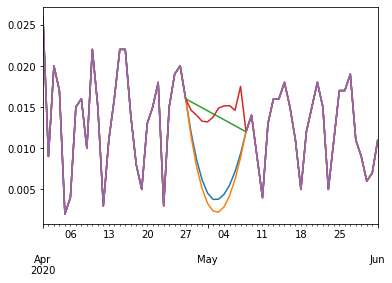

In [820]:
ts = data['Reseda']['no2']
ts.interpolate(method='polynomial', order=2)['2020-04-01':'2020-06-01'].plot()
ts.interpolate(method='cubicspline')['2020-04-01':'2020-06-01'].plot()
ts.interpolate(method='time')['2020-04-01':'2020-06-01'].plot()
ts.fillna(ts.rolling(14, min_periods=3).mean())['2020-04-01':'2020-06-01'].plot()
ts['2020-04-01':'2020-06-01'].plot()

# Combine into single dataframe

In [745]:
all_dfs = []
for site, df in data.items():
    df['Site'] = [site] * len(df)
    df['TAVG'] = ((df['TMIN'] + df['TMAX']) / 2)
    all_dfs.append(df)

combined_df = pd.concat(all_dfs)
combined_df.loc['2020-01-01']

,no2,ozone,pm25,PRCP,AWND,TMAX,TMIN,Site,TAVG
2020-01-01,0.029,0.041,32.7,0.0,2.91,67.0,49.0,Compton,58.0
2020-01-01,0.032,0.038,18.7,0.0,1.34,70.0,49.0,LA,59.5
2020-01-01,NaN,0.041,29.8,0.0,2.46,65.0,45.0,LBSH,55.0
2020-01-01,0.028,0.047,17.5,0.0,NaN,71.0,38.0,Reseda,54.5


In [821]:
combined_df.to_csv('4_Site_Air_2020')

# Plots

In [478]:
from sklearn import preprocessing
for col in ['TMAX']:
    # Create x, where x the 'scores' column's values as floats
    x = data['LA'][[col]].values.astype(float)

    # Create a minimum and maximum processor object
    min_max_scaler = preprocessing.MinMaxScaler()

    # Create an object to transform the data to fit minmax processor
    x_scaled = min_max_scaler.fit_transform(x)

    # Run the normalizer on the dataframe
    df_normalized = pd.DataFrame(x_scaled)
#     plt.plot(x_scaled)
# data['LA'].columns

In [631]:
dfs = [(site, df['no2']) for site, df in data.items()]

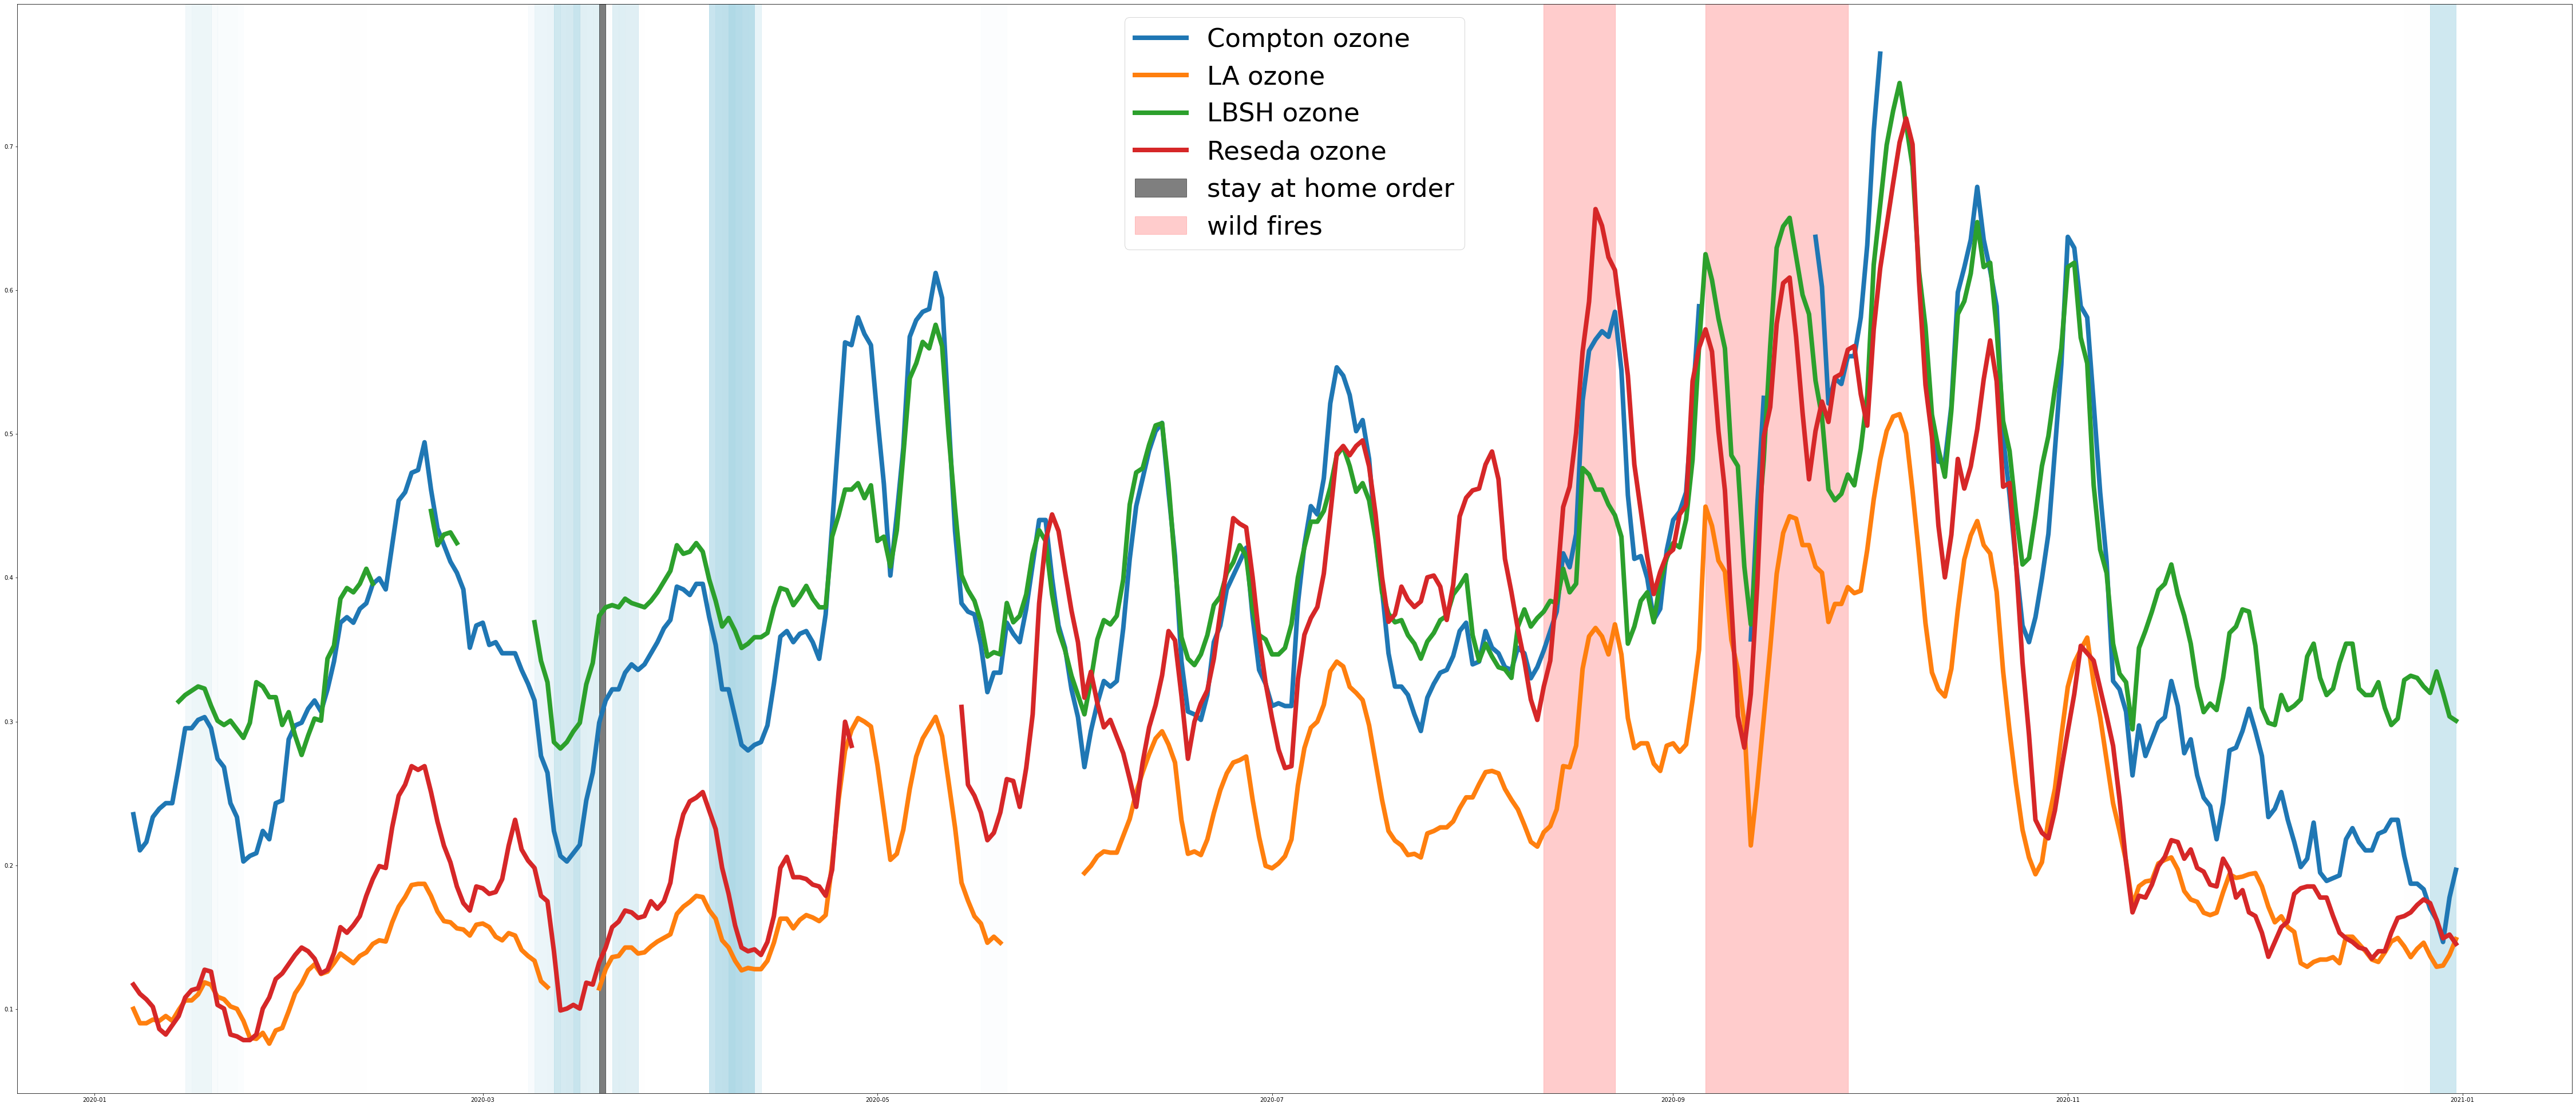

In [734]:
fig = plt.figure(figsize=(80, 35))

# for df in dfs:
#     plt.plot(df[1].rolling(7).mean(), label=df[0], lw=10)


# ax[i].fill_between(list(range(1, len(x[1])+1)), test[var].rolling(7).mean(),color='mediumseagreen', label='prev decade avg')
# Wet months

var = 'ozone'
for location in data.keys():
    c_r_df = data[location][var]

    # Create x, where x the 'scores' column's values as floats
    x = c_r_df.values.astype(float)
    # print(x.reshape(-1, 1))
    # Create a minimum and maximum processor object
    min_max_scaler = preprocessing.MinMaxScaler()

    # Create an object to transform the data to fit minmax processor
    x_scaled = min_max_scaler.fit_transform(x.reshape(-1, 1))

    # Run the normalizer on the dataframe
    df_normalized = pd.DataFrame(x_scaled)


    df_normalized.index = c_r_df.index


    plt.plot(df_normalized.rolling(7).mean(), label=f'{location} {var}', lw=8)


# Plot rain
for i, row in data['Compton'].iterrows():
    if row['PRCP'] > 0:
        plt.axvspan(i - pd.DateOffset(1), i + pd.DateOffset(3), alpha=row['PRCP'], color='lightblue')


# Stay at home dates
plt.axvspan('2020-03-19', '2020-03-20', alpha=0.5, color='black', label='stay at home order')

# Fire dates
# http://www.aqmd.gov/home/news-events/news-and-media/2020-news-archives
plt.axvspan('2020-08-12', '2020-08-23', alpha=0.2, color='red', label='wild fires')
plt.axvspan('2020-09-06', '2020-09-28', alpha=0.2, color='red')  

    
plt.legend(prop={'size': 45})
plt.show()


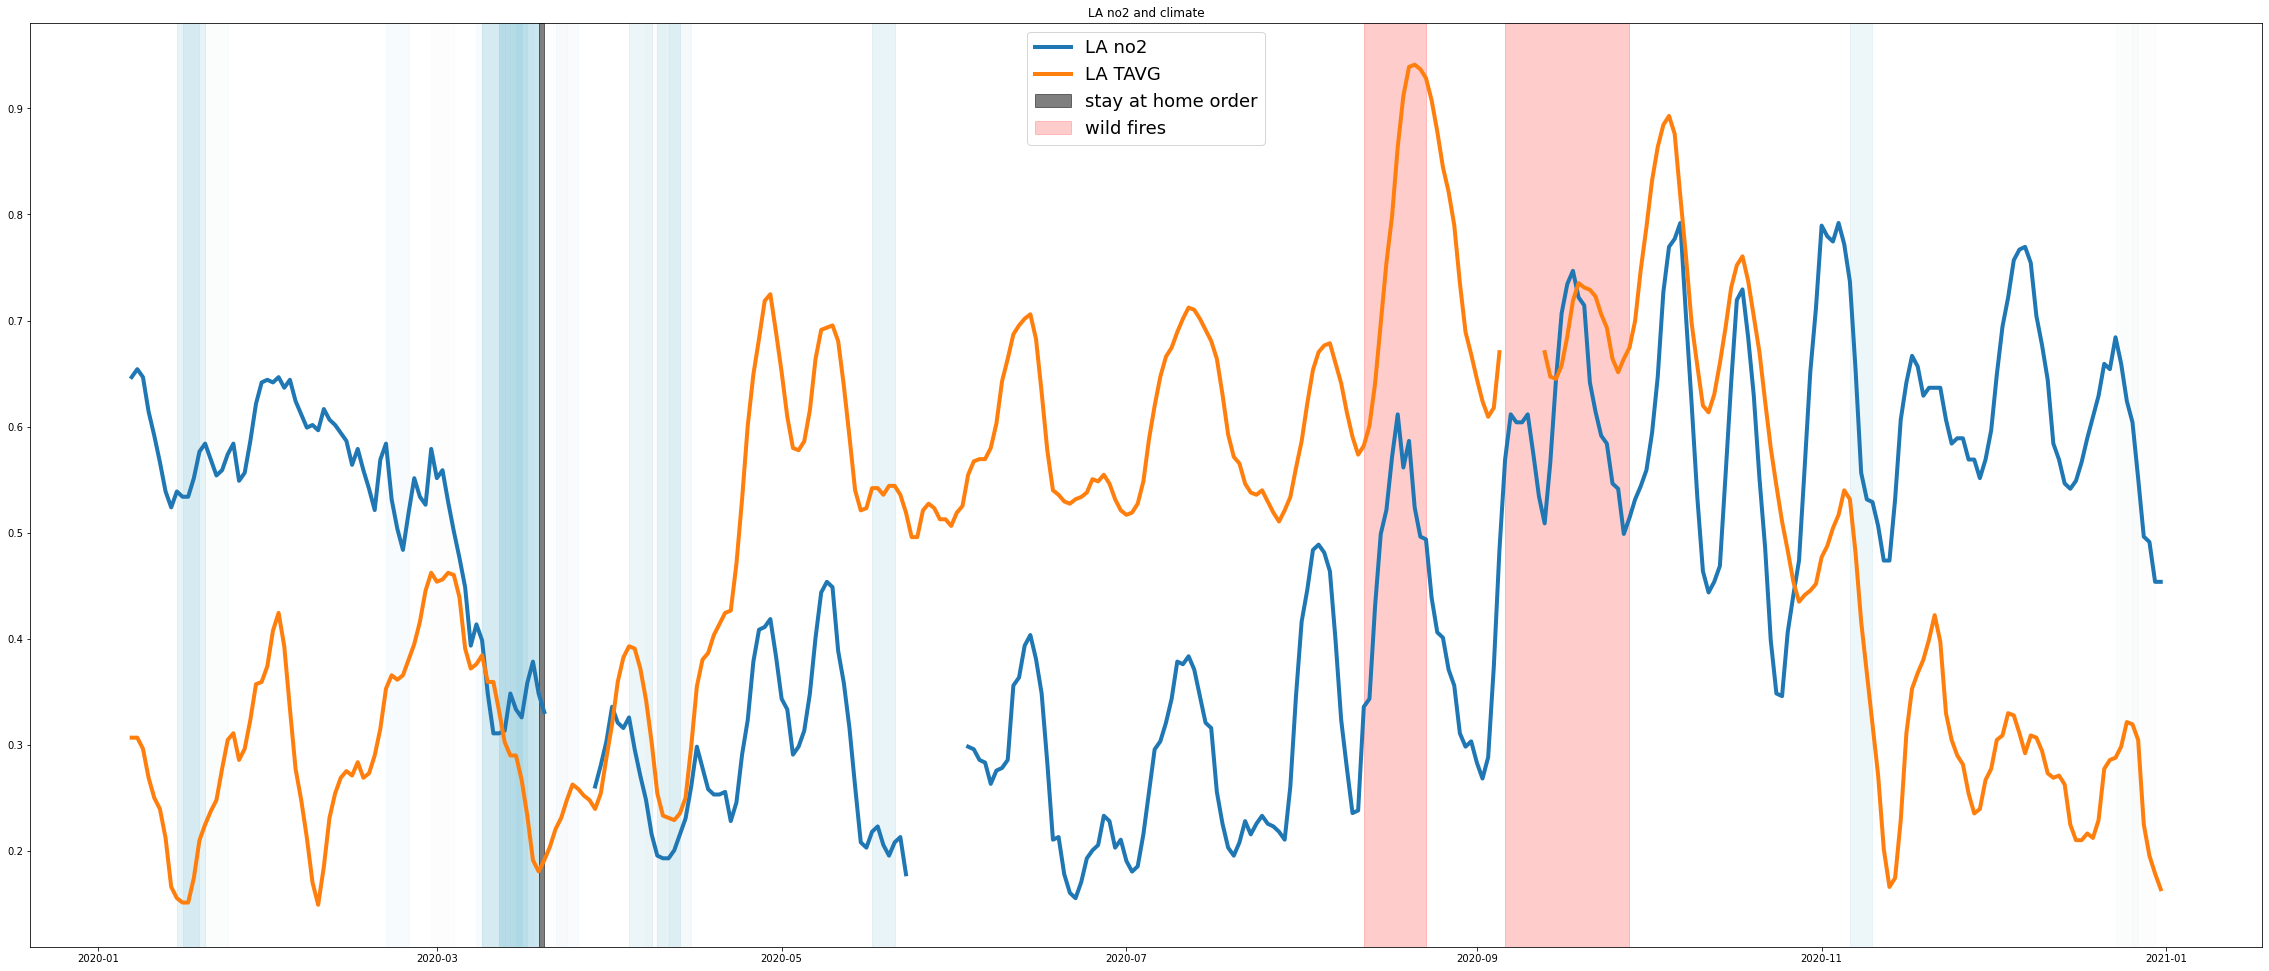

In [735]:
fig = plt.figure(figsize=(40, 17))

# for df in dfs:
#     plt.plot(df[1].rolling(7).mean(), label=df[0], lw=10)


# ax[i].fill_between(list(range(1, len(x[1])+1)), test[var].rolling(7).mean(),color='mediumseagreen', label='prev decade avg')
# Wet months
la_df = data['LA']
la_df['TAVG'] = ((data['LA']['TMIN'] + data['LA']['TMAX']) / 2)

var = 'no2'
dvars = ['no2', 'TAVG']
for var in dvars:

    # Create x, where x the 'scores' column's values as floats
    x = la_df[var].values.astype(float)
    # print(x.reshape(-1, 1))
    # Create a minimum and maximum processor object
    min_max_scaler = preprocessing.MinMaxScaler()

    # Create an object to transform the data to fit minmax processor
    x_scaled = min_max_scaler.fit_transform(x.reshape(-1, 1))

    # Run the normalizer on the dataframe
    df_normalized = pd.DataFrame(x_scaled)


    df_normalized.index = la_df.index


    plt.plot(df_normalized.rolling(7).mean(), label=f'LA {var}', lw=4)


# Plot rain
    for i, row in la_df.iterrows():
        if row['PRCP'] > 0:
            plt.axvspan(i - pd.DateOffset(1), i + pd.DateOffset(3), alpha=row['PRCP'], color='lightblue')


# Stay at home dates
plt.axvspan('2020-03-19', '2020-03-20', alpha=0.5, color='black', label='stay at home order')

# Fire dates
# http://www.aqmd.gov/home/news-events/news-and-media/2020-news-archives
plt.axvspan('2020-08-12', '2020-08-23', alpha=0.2, color='red', label='wild fires')
plt.axvspan('2020-09-06', '2020-09-28', alpha=0.2, color='red')  

plt.title('LA no2 and climate')
plt.legend(prop={'size': 18})
plt.show()



In [728]:
data['LA'][dvars].corr()

,no2,ozone,pm25,AWND,TAVG
no2,1.000000,0.270930,0.334346,-0.550846,0.074545
ozone,0.270930,1.000000,0.446264,-0.159169,0.753440
pm25,0.334346,0.446264,1.000000,-0.352162,0.323060
AWND,-0.550846,-0.159169,-0.352162,1.000000,-0.015610
TAVG,0.074545,0.753440,0.323060,-0.015610,1.000000


<AxesSubplot:>

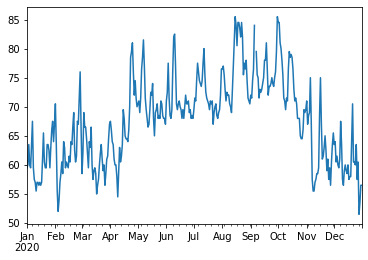

In [720]:
((data['LA']['TMIN'] + data['LA']['TMAX']) / 2).plot()

In [714]:
data['Compton'][dvars].corr()

,ozone,AWND,TMAX
ozone,1.000000,0.035864,0.603144
AWND,0.035864,1.000000,-0.034254
TMAX,0.603144,-0.034254,1.000000


In [715]:
data['LBSH'][dvars].corr()

,ozone,AWND,TMAX
ozone,1.000000,-0.016981,0.542341
AWND,-0.016981,1.000000,0.105836
TMAX,0.542341,0.105836,1.000000


In [736]:
data['Compton']

,no2,ozone,pm25,PRCP,AWND,TMAX,TMIN
2020-01-01,0.029,0.041,32.7,0.00,2.91,67.0,49.0
2020-01-02,0.040,0.034,22.0,0.00,2.24,67.0,51.0
2020-01-03,0.045,0.021,25.3,0.00,1.34,73.0,49.0
2020-01-04,0.041,0.033,36.8,0.00,2.01,69.0,48.0
2020-01-05,0.034,0.038,36.5,0.00,1.79,69.0,48.0
...,...,...,...,...,...,...,...
2020-12-27,0.022,0.030,15.4,0.00,2.91,63.0,54.0
2020-12-28,0.024,0.029,12.3,1.58,4.70,55.0,45.0
2020-12-29,0.041,0.026,18.2,0.00,2.68,65.0,42.0
2020-12-30,0.038,0.032,22.8,0.00,1.57,68.0,41.0
